***
# <center>Generando la estructura de datos necesaria para aplicar <b>mmcIsingCiclovia</b></center> <a class="tocSkip"></a>

Acá pretendo construir un programa genere estructuras de datos de prueba para `mmcIsingCiclovia` a partir de archivos **.geojson** cuyos *features* sean *polígonos*.

# Transformando los datos de las manzanas a DataFrames

In [1]:
using GeoJSON
using DataFrames
manzanas = GeoJSON.parsefile("cdmx_manzanas.geojson")
manz_dict = geo2dict(manzanas);

In [2]:
list_df_manz = []
for i in 1:65993    
    coords_manzi = get(get(get(manz_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    manzi_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_manzi,1)
        push!(manzi_df, coords_manzi[j])
    end
    push!(list_df_manz,manzi_df)
end

El número total de manzanas (65993) lo tuve por fuerza bruta, haciendo el ciclo de la 2da línea
```julia
for i in 1:1000000
```
y observando el error que saltó. Aún no sé cómo encontrar el tamaño de los diccionarios anidados con esa estructura. Las coordenadas de cada manzana están en un `DataFrame` que es elemento de la lista `list_df_manz`. 

## *Paréntesis* Como son muchos datos probablemente convenga tener listo el multithreading

In [3]:
Threads.nthreads()

4

In [4]:
a = zeros(10)
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

10-element Array{Float64,1}:
 1.0
 1.0
 1.0
 2.0
 2.0
 2.0
 3.0
 3.0
 4.0
 4.0

## Una prueba graficando los datos de manzanas dentro de la lista de DataFrames

In [5]:
using PyPlot
using PyCall
plt = pyimport("matplotlib.pyplot")
jtp = pyimport("jupyterthemes.jtplot")
jtp.style(theme="chesterish")

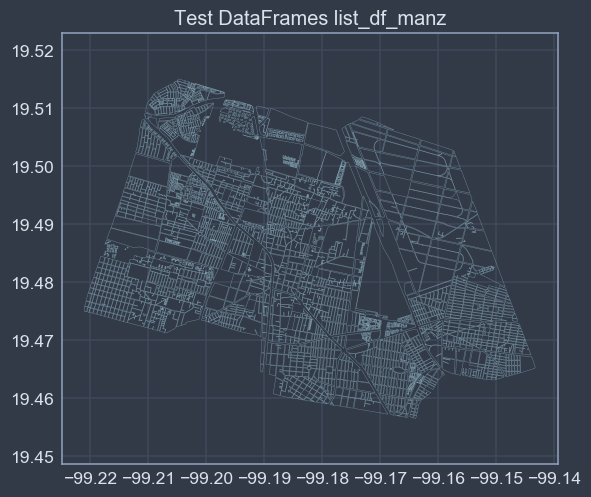

9.048517 seconds (2.50 M allocations: 125.226 MiB, 0.94% gc time)


In [6]:
@time begin
    
fig = plt.figure()
plt.title("Test DataFrames list_df_manz")

for i in 1:3000
    plt.plot(list_df_manz[i].x, list_df_manz[i].y, "-", color="lightblue", lw=0.3, alpha=0.5);
end
plt.axis("equal")
plt.show()
fig.savefig("Manzanas_test.png", writer="imagemagick")
    
end

Se puede comenzar a ver la diferencia de performance de `matplotlib` al aumentar el número de puntos a graficar este caso. Los ciclos que llaman a `matplotlib` no se pueden hacer con el multithread nativo de Julia (casi que por obvias razones).

Al parecer, hay que estudiar más sobre el orden que pudieran tener los elementos de la lista `list_df_manz`, si es que tiene algún orden. Analizando el primer elemento del .geojson parece que cada manzana tiene asociados los datos:
```
"CVEGEO": "0900200010985032"
"CVE_ENT": "09"
"CVE_MUN": "002"
"CVE_LOC": "0001"
"CVE_AGEB": "0985"
"CVE_MZA": "032"
"AMBITO": "Urbana"
"TIPOMZA": "Contenedora"
```
que pueden ser útiles después, habrá que ver cómo se pueden extraer del diccionario `manz_dict` y asociarlos con la lista.

In [7]:
get(get(manz_dict,"features", 1)[1],"properties",1)

Dict{String,Any} with 8 entries:
  "CVE_ENT"  => "09"
  "CVE_LOC"  => "0001"
  "TIPOMZA"  => "Contenedora"
  "AMBITO"   => "Urbana"
  "CVE_AGEB" => "0985"
  "CVEGEO"   => "0900200010985032"
  "CVE_MUN"  => "002"
  "CVE_MZA"  => "032"

Efectivamente, esas propiedades también están en `manz_dict`.

# Transformando los datos de distritos a DataFrames

In [8]:
distritos = GeoJSON.parsefile("cdmx_distritos.geojson")
dist_dict = geo2dict(distritos);

In [9]:
list_df_dist = []
for i in 1:85
    coords_disti = get(get(get(dist_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    disti_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_disti,1)
        push!(disti_df, coords_disti[j])
    end
    push!(list_df_dist,disti_df)
end

Acá el número de distritos (85), aunque en total son más, la estrutura de los datos me permitió conocer que para la ciudad de méxico sólo son necesarios los *primeros* 85. Las coordenadas de cada distrito están en un `DataFrame` que es elemento de la lista `list_df_dist`, convenientemente ordenada según el mapa del PlanBICI-CDMX.

## Una prueba graficando los datos de distritos dentro de la lista de DataFrames

In [10]:
bpl = pyimport("bokeh.plotting")
ipd = pyimport("IPython.display");

In [11]:
@time begin

bpl.output_file("distritos.html", mode="inline")
p = bpl.figure(title="D 1-2", aspect_scale=1,
    background_fill_color="#efefef", background_fill_alpha=0.85)
for i in 1:85
    p.line(list_df_dist[i].x, list_df_dist[i].y, color="#323a48", line_width=3, alpha=0.8);
end
bpl.save(p)
ipd = pyimport("IPython.display")
ipd.IFrame(src="distritos.html", width=650, height=680)
    
end

  0.744069 seconds (606.26 k allocations: 30.923 MiB, 2.21% gc time)


PyObject <IPython.lib.display.IFrame object at 0x7fbf06500860>

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/html")}, ::PyObject) at PyCall.jl:895
└ @ PyCall /home/arthurod/.julia/packages/PyCall/ttONZ/src/PyCall.jl:895


Graficar con `bokeh` fue suficientemete rápido y con buenos resultados. Habrá que hacer más pruebas, sobre todo con conjuntos de datos mucho más grandes, como los de manzanas.

# Buscando las manzanas pertenecientes a dos distritos
Me di cuenta que con QGIS, en la parte de `Vector -> GeoProcessing Tools -> Clip` se pueden separar las manzanas pertenecientes a un distrito de tránsito. Luego:

In [12]:
manzanas1 = GeoJSON.parsefile("manz_dist1.geojson")
manz1_dict = geo2dict(manzanas1)
manzanas2 = GeoJSON.parsefile("manz_dist2.geojson")
manz2_dict = geo2dict(manzanas2);

In [13]:
list_df_manz_dist1 = []
list_df_manz_dist2 = []

for i in 1:397   
    coords_manzi = get(get(get(manz1_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    manzi_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_manzi,1)
        push!(manzi_df, coords_manzi[j])
    end
    push!(list_df_manz_dist1,manzi_df)
end

for i in 1:677    
    coords_manzi = get(get(get(manz2_dict,"features", 1)[i],"geometry",1),"coordinates",1)[1][1]
    manzi_df = DataFrame(x = Float64[], y = Float64[])
    for j in 1:size(coords_manzi,1)
        push!(manzi_df, coords_manzi[j])
    end
    push!(list_df_manz_dist2,manzi_df)
end

## Graficando

In [14]:
@time begin

bpl.output_file("Test_manz-dist12.html", mode="inline")
p = bpl.figure(title="D 1-2", aspect_scale=1,
    background_fill_color="#efefef", background_fill_alpha=0.85)
    
for i in 1:397
    p.line(list_df_manz_dist1[i].x, list_df_manz_dist1[i].y, color="orange", line_width=1, alpha=0.8);
end
    
for i in 1:677
    p.line(list_df_manz_dist2[i].x, list_df_manz_dist2[i].y, color="orange", line_width=1, alpha=0.8);
end
    
for i in 1:2
    p.line(list_df_dist[i].x, list_df_dist[i].y, color="#323a48", line_width=3, alpha=0.8);
end
    
bpl.save(p)
ipd = pyimport("IPython.display")
ipd.IFrame(src="Test_manz-dist12.html", width=650, height=680)
    
end

  5.439707 seconds (63.96 k allocations: 3.115 MiB)


PyObject <IPython.lib.display.IFrame object at 0x7fbf03fb44a8>

# Explorando otra opción con el .json descargado de [OSM-Traffic](http://osm-traffic.com/)

In [146]:
using JSON
using DataFrames
dist12_network_dict = JSON.parsefile("dist12-roads.json")

Dict{String,Any} with 2 entries:
  "features" => Any[Dict{String,Any}("properties"=>Dict{String,Any}("name"=>"Cd…
  "type"     => "FeatureCollection"

In [147]:
dist12_network_features_list = get(dist12_network_dict,"features", 1);

In [148]:
size(dist12_network_features_list,1)

14150

## Los edges
Son de tipo `"LineString"`

In [149]:
dist12_network_features_list[1]

Dict{String,Any} with 5 entries:
  "properties" => Dict{String,Any}("name"=>"Cda. de Plaza Rio de Janeiro","clas…
  "geometry"   => Dict{String,Any}("coordinates"=>Any[Any[-99.1611, 19.4221], A…
  "to"         => 2
  "from"       => 1
  "type"       => "Feature"

In [150]:
get(dist12_network_features_list[1],"properties", 1)

Dict{String,Any} with 5 entries:
  "name"    => "Cda. de Plaza Rio de Janeiro"
  "class"   => "LNLink"
  "id"      => 0
  "highway" => "residential"
  "lanes"   => "1"

In [151]:
get(dist12_network_features_list[1],"geometry", 1)

Dict{String,Any} with 2 entries:
  "coordinates" => Any[Any[-99.1611, 19.4221], Any[-99.1611, 19.422], Any[-99.1…
  "type"        => "LineString"

In [152]:
get(get(dist12_network_features_list[1],"geometry", 1),"coordinates",1)

3-element Array{Any,1}:
 Any[-99.1611, 19.4221]
 Any[-99.1611, 19.422] 
 Any[-99.161, 19.4215] 

## Los nodes
Son de tipo `"Point"`

In [153]:
dist12_network_features_list[14000]

Dict{String,Any} with 3 entries:
  "properties" => Dict{String,Any}("class"=>"LNNode","id"=>977)
  "geometry"   => Dict{String,Any}("coordinates"=>Any[-99.1766, 19.4346],"type"…
  "type"       => "Feature"

In [154]:
get(dist12_network_features_list[14000],"properties", 1)

Dict{String,Any} with 2 entries:
  "class" => "LNNode"
  "id"    => 977

In [155]:
get(get(dist12_network_features_list[14000],"properties", 1),"id", 1)

977

In [156]:
get(dist12_network_features_list[14000],"geometry", 1)

Dict{String,Any} with 2 entries:
  "coordinates" => Any[-99.1766, 19.4346]
  "type"        => "Point"

In [157]:
get(get(dist12_network_features_list[14000],"geometry", 1),"type", 1)

"Point"

In [158]:
get(get(dist12_network_features_list[14000],"geometry", 1),"coordinates", 1)

2-element Array{Any,1}:
 -99.17655944824219 
  19.434640884399414

## Creando el DataFrame de nodes

In [159]:
dist12_network_nodes_df = DataFrame(id_nodo = Int64[], x = Float64[], y = Float64[])

for i in 1:size(dist12_network_features_list,1)
    tp = get(get(dist12_network_features_list[i],"geometry", 1),"type", 1)
    if tp == "Point"
        id = get(get(dist12_network_features_list[i],"properties", 1),"id", 1)
        x = get(get(dist12_network_features_list[i],"geometry", 1),"coordinates", 1)[1]
        y = get(get(dist12_network_features_list[i],"geometry", 1),"coordinates", 1)[2]
        push!(dist12_network_nodes_df,[id,x,y])
    end
end

In [160]:
size(dist12_network_nodes_df)

(5334, 3)

In [175]:
sort!(dist12_network_nodes_df)
first(dist12_network_nodes_df,10)

,id_nodo,x,y
,Int64,Float64,Float64
1,1,-99.1611,19.4221
2,2,-99.161,19.4215
3,4,-99.1572,19.4213
4,5,-99.157,19.4206
5,7,-99.1618,19.4232
6,8,-99.1616,19.4226
7,10,-99.1594,19.4246
8,11,-99.1612,19.4242
9,13,-99.165,19.4206


In [162]:
get(get(dist12_network_features_list[1],"geometry", 1),"coordinates",1)

3-element Array{Any,1}:
 Any[-99.1611, 19.4221]
 Any[-99.1611, 19.422] 
 Any[-99.161, 19.4215] 

In [163]:
get(dist12_network_features_list[1],"from",0)

1

In [164]:
get(dist12_network_features_list[1],"to",0)

2

In [173]:
dist12_network_nodes_df.x[1] == get(get(dist12_network_features_list[1],"geometry", 1),"coordinates",1)[1][1]

true

In [174]:
dist12_network_nodes_df.x[2] == get(get(dist12_network_features_list[1],"geometry", 1),"coordinates",1)[3][1]

true

## Creando el DataFrame de edges

In [167]:
dist12_network_edges_df = DataFrame(nodo_origen = Int64[], nodo_destino = Int64[], camino = Array[])

for i in 1:size(dist12_network_features_list,1)
    tp = get(get(dist12_network_features_list[i],"geometry", 1),"type", 1)
    if tp == "LineString"
        id_from = get(dist12_network_features_list[i],"from",0)
        id_to = get(dist12_network_features_list[i],"to",0)
        crds = get(get(dist12_network_features_list[i],"geometry", 1),"coordinates",1)
        push!(dist12_network_edges_df,[id_from,id_to,crds])
    end
end

In [168]:
size(dist12_network_edges_df)

(8816, 3)

In [176]:
sort!(dist12_network_edges_df)
first(dist12_network_edges_df,30)

,nodo_origen,nodo_destino,camino
,Int64,Int64,Array
1,1,2,"[Any[-99.1611, 19.4221], Any[-99.1611, 19.422], Any[-99.161, 19.4215]]"
2,2,10843,"[Any[-99.161, 19.4215], Any[-99.1609, 19.4211], Any[-99.1609, 19.4211], Any[-99.1609, 19.421], Any[-99.1609, 19.421]]"
3,4,5,"[Any[-99.1572, 19.4213], Any[-99.157, 19.4206]]"
4,5,8084,"[Any[-99.157, 19.4206], Any[-99.1563, 19.4207]]"
5,7,8,"[Any[-99.1618, 19.4232], Any[-99.1616, 19.4226]]"
6,8,1899,"[Any[-99.1616, 19.4226], Any[-99.1622, 19.4224]]"
7,10,11,"[Any[-99.1594, 19.4246], Any[-99.1596, 19.4246], Any[-99.1612, 19.4242]]"
8,10,8452,"[Any[-99.1594, 19.4246], Any[-99.1596, 19.4246], Any[-99.1602, 19.4245]]"
9,11,1875,"[Any[-99.1612, 19.4242], Any[-99.1646, 19.4234]]"


Verificando que los ids muy grandes de los nodos estén en el DataFrame de nodos

In [177]:
last(dist12_network_nodes_df,10)

,id_nodo,x,y
,Int64,Float64,Float64
1,13873,-99.1758,19.4581
2,13905,-99.159,19.4037
3,13936,-99.1666,19.4664
4,13948,-99.1375,19.4706
5,14025,-99.1805,19.4241
6,14036,-99.1705,19.4004
7,14038,-99.179,19.4685
8,14083,-99.1663,19.4695
9,14085,-99.1785,19.4177


Verificando si los tamaños coinciden

In [171]:
size(dist12_network_nodes_df)[1] + size(dist12_network_edges_df)[1]

14150

## Haciendo una figura de prueba

In [234]:
using DataFramesMeta
using PyCall
bpl = pyimport("bokeh.plotting");

In [235]:
@time begin
    
bpl.output_file("Test_Gráfica.html", mode="inline")
p = bpl.figure(title="Test_Gráfica", aspect_scale=1,
    background_fill_color="#efefef", background_fill_alpha=0.85)
    
for i in 1:size(dist12_network_edges_df,1)
    x_from = (@linq dist12_network_nodes_df |>
           where(:id_nodo .== dist12_network_edges_df.nodo_origen[i]) |>
           select(:x, :y)).x
    y_from = (@linq dist12_network_nodes_df |>
           where(:id_nodo .== dist12_network_edges_df.nodo_origen[i]) |>
           select(:x, :y)).y
    x_to = (@linq dist12_network_nodes_df |>
           where(:id_nodo .== dist12_network_edges_df.nodo_destino[i]) |>
           select(:x, :y)).x
    y_to = (@linq dist12_network_nodes_df |>
           where(:id_nodo .== dist12_network_edges_df.nodo_destino[i]) |>
           select(:x, :y)).y
    p.square(x_from, y_from, size=2, color="olive", alpha=0.8)
    p.square(x_to, y_to, size=2, color="olive", alpha=0.8)
    
    x_way = []
    y_way = []
    for j in 1:size(dist12_network_edges_df.camino[i],1)
        push!(x_way,dist12_network_edges_df.camino[i][j][1])
        push!(y_way,dist12_network_edges_df.camino[i][j][2])
    end
    p.line(x_way, y_way, color="#323a48", line_width=1, alpha=0.8)
end

for i in 1:397
    p.line(list_df_manz_dist1[i].x, list_df_manz_dist1[i].y, color="orange", line_width=1, alpha=0.5);
end
    
for i in 1:677
    p.line(list_df_manz_dist2[i].x, list_df_manz_dist2[i].y, color="orange", line_width=1, alpha=0.5);
end
    
for i in 1:2
    p.line(list_df_dist[i].x, list_df_dist[i].y, color="red", line_width=3, alpha=0.8);
end

bpl.save(p)
    
end

719.171808 seconds (4.06 M allocations: 400.875 MiB, 0.03% gc time)


"/home/arthurod/programming/npb-cdmx/Test_Gráfica.html"

## Exportando a CSV

In [236]:
using CSV
CSV.write("dist12_network_edges.csv", dist12_network_edges_df)
CSV.write("dist12_network_nodes.csv", dist12_network_nodes_df)

┌ Info: Recompiling stale cache file /home/arthurod/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


"dist12_network_nodes.csv"